## Avaliação em holdouts - LASTFM

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
## Read Data

In [4]:
# importa dataset 'palco playlists'
data = pd.read_csv('output/lastfm_dump/sampled_lastfm.csv')
user_col = 'user_id'
item_col = 'item_id'

In [5]:
data.shape, data[user_col].nunique(), data[item_col].nunique()

((302973, 7), 43, 78944)

In [6]:
data[[user_col, item_col]].duplicated().sum()

202387

In [7]:
data.shape

(302973, 7)

In [8]:
data.head()

,user_id,item_id,timestamp,date2,year,month,date
0,user_000709,02bdbc7e-a1d8-4038-ab56-b1c9d16abb5f,2008-01-08T13:01:24Z,2008-01-08,2008,1,2008-01-01
1,user_000709,22ea4524-3dcb-44e6-a1bc-4edfd25ad988,2008-01-08T13:05:57Z,2008-01-08,2008,1,2008-01-01
2,user_000709,72930b59-2fe0-414d-b384-d65897bd3cf5,2008-01-08T13:09:54Z,2008-01-08,2008,1,2008-01-01
3,user_000709,cf482a0f-4d85-4f89-8650-a244072bc79f,2008-01-08T13:14:11Z,2008-01-08,2008,1,2008-01-01
4,user_000709,e57b097a-9848-4701-b2c6-34b4b8281e3c,2008-01-08T13:18:31Z,2008-01-08,2008,1,2008-01-01


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302973 entries, 0 to 302972
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    302973 non-null  object
 1   item_id    302973 non-null  object
 2   timestamp  302973 non-null  object
 3   date2      302973 non-null  object
 4   year       302973 non-null  int64 
 5   month      302973 non-null  int64 
 6   date       302973 non-null  object
dtypes: int64(2), object(5)
memory usage: 16.2+ MB


### Convert timestamp

In [10]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 1.98 s, sys: 0 ns, total: 1.98 s
Wall time: 1.98 s


In [11]:
data.head()

,user_id,item_id,timestamp,date2,year,month,date
0,user_000709,02bdbc7e-a1d8-4038-ab56-b1c9d16abb5f,2008-01-08T13:01:24Z,2008-01-08,2008,1,2008-01-01
1,user_000709,22ea4524-3dcb-44e6-a1bc-4edfd25ad988,2008-01-08T13:05:57Z,2008-01-08,2008,1,2008-01-01
2,user_000709,72930b59-2fe0-414d-b384-d65897bd3cf5,2008-01-08T13:09:54Z,2008-01-08,2008,1,2008-01-01
3,user_000709,cf482a0f-4d85-4f89-8650-a244072bc79f,2008-01-08T13:14:11Z,2008-01-08,2008,1,2008-01-01
4,user_000709,e57b097a-9848-4701-b2c6-34b4b8281e3c,2008-01-08T13:18:31Z,2008-01-08,2008,1,2008-01-01


CPU times: user 119 ms, sys: 722 µs, total: 120 ms
Wall time: 118 ms


Text(0.5, 1.0, 'interactions per month')

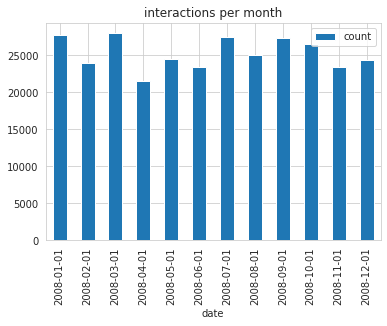

In [12]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

___
## Get intervals and Frequent users (threshold = 0.75)

time intervals

In [13]:
# user_presence_df = pd.read_csv('output/amazon_digmusic_dump/sample_user_presence_df.csv')
# user_month_interactions = pd.read_csv('output/amazon_digmusic_dump/sample_user_month_interactions.csv')
# frequent_users_month = joblib.load('output/amazon_digmusic_dump/sample_frequent_users_month.joblib')

___
## Experiments using months

In [14]:
data.shape

(302973, 7)

In [15]:
%%time
# 1min 29s
buckets, holdouts = getBucketsHoldouts(
    data=data,# data[ data['date'].dt.month==1 ],# 
    user_col=user_col,
    item_col=item_col,
    frequent_users=data['user_id'].unique(),# frequent_users_month, # for every user in holdout: data['user_id'].unique()
    interval_type='M',
    intervals=None, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 21
common interactions between holdout 2 and all buckets: 20
common interactions between holdout 3 and all buckets: 22
common interactions between holdout 4 and all buckets: 25
common interactions between holdout 5 and all buckets: 29
common interactions between holdout 6 and all buckets: 28
common interactions between holdout 7 and all buckets: 22
common interactions between holdout 8 and all buckets: 23
common interactions between holdout 9 and all buckets: 28
common interactions between holdout 10 and all buckets: 27
common interactions between holdout 11 and all buckets: 20
common interactions between holdout 12 and all buckets: 22
Converting to ImplicitData. . .
Done!
CPU times: user 9.05 s, sys: 39.5 ms, total: 9.09 s
Wall time: 9.06 s


In [16]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

302973

In [17]:
joblib.dump(buckets, 'output/lastfm_dump/sample_buckets.joblib')
joblib.dump(holdouts, 'output/lastfm_dump/sample_holdouts.joblib')

['output/lastfm_dump/sample_holdouts.joblib']

In [18]:
buckets = joblib.load( 'output/lastfm_dump/sample_buckets.joblib')
holdouts = joblib.load( 'output/lastfm_dump/sample_holdouts.joblib')

In [19]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(27682, 31, 12381),
 (23932, 34, 13474),
 (27971, 35, 12820),
 (21449, 36, 12106),
 (24527, 35, 12446),
 (23418, 36, 13725),
 (27461, 35, 15909),
 (24929, 36, 12734),
 (27306, 33, 15253),
 (26427, 34, 14734),
 (23383, 36, 12449),
 (24354, 38, 13921)]

In [20]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(10, 10, 10),
 (14, 14, 14),
 (13, 13, 13),
 (11, 11, 11),
 (6, 6, 6),
 (9, 9, 9),
 (13, 13, 13),
 (13, 13, 13),
 (5, 5, 5),
 (7, 7, 7),
 (16, 16, 16),
 (17, 17, 17)]

### ISGD

In [22]:
%%time
import itertools
def grid_search(model, buckets, holdouts, random_seed = 10):  #  stream,  interleaved=10
    num_factors = [50, 100, 150, 200]
    num_iter = [1, 2, 5, 8]
    learn_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
    regularization = [0.01, 0.05, 0.1, 0.25, 0.5]
    # num_nodes = [1, 2, 4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization]
    grid = list(itertools.product(*grid))
    results = []
    p0 = -1
    for i, hp in enumerate(grid):
        progress = ((i*100)//len(grid))
        if progress%5==0 and progress!=p0:
            p0=progress
            print(progress, '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        eval = EvaluateHoldouts(model=m, buckets=buckets, holdouts=holdouts)
        # e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        # result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')
        
        rm = eval.results_matrix
        result=rm[0,0]
        # results.append( np.mean(result['Recall@N']) )
        results.append( result )
    return grid, results    

# OPTIONAL FOR NOW
# prop = 0.05 # 0.05
# hp_sample = data.iloc[:round( data.shape[0]*prop )]
# stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
grid, results = grid_search(model=ISGD, buckets=[buckets[0]], holdouts=[holdouts[0]], random_seed=10) # stream=stream,  , interleaved=1 
len(grid), len(results), max(results) # (243, 243, 0.0026656511805026656)

0 %
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
-------------------------------------------------------------------------------

/home/klismam/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:112: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * q_i - self.user_regularization * p_u)
/home/klismam/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:119: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)
/home/klismam/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:119: RuntimeWarning: invalid value encountered in subtract
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)


Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0


/home/klismam/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:113: RuntimeWarning: invalid value encountered in add
  p_u += delta


Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
--------------------------------------------------------------------

(400, 400, 0.0)

In [24]:
# none of the hyperparameters work to improve results in the first bucket . . . what now

# # num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ]
print( grid[ np.argmax( results ) ] )
num_factors, num_iter, learn_rate, regularization = grid[ np.argmax( results ) ] # meh just ignore this (150, 8, 0.5, 0.3, 4)

(50, 1, 0.01, 0.01)


In [31]:
# define hyperparameters
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [25]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [26]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [27]:
%%time
# 1h 4min 44s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 2
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 3
Test Holdout 3
recommendations not made for users in holdout 3 x checkpoint 0: 2
Test Holdout 4
Test Holdout 5
recommendations not made for users in holdout 5 x checkpoint 0: 4
Test Holdout 6
recommendations not made for users in holdout 6 x checkpoint 0: 2
Test Holdout 7
recommendations not made for users in holdout 7 x checkpoint 0: 2
Test Holdout 8
recommendations not made for users in holdout 8 x checkpoint 0: 1
Test Holdout 9
recommendations not made for users in holdout 9 x checkpoint 0: 2
Test Holdout 10
recommendations not made for users in holdout 10 x checkpoint 0: 6
Test Holdout 11
recommendations not made for users in holdout 11 x checkpoint 0: 8
----------------------------------------

KeyboardInterrupt: 

In [ ]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/lastfm_dump/sample_lastfm month_bucket ISGD results.csv', index=False)

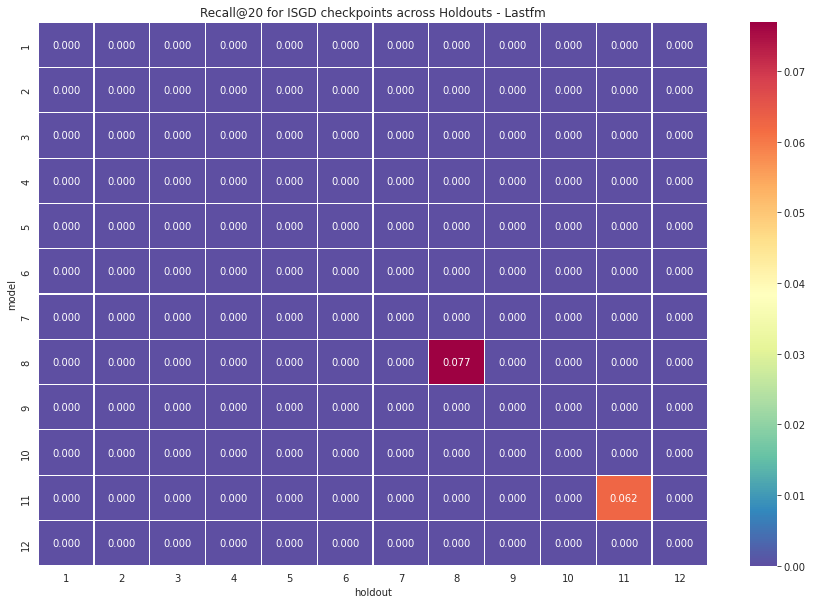

In [ ]:
recall_heatmap(df,
    round_point=3,
    title='Recall@20 for ISGD checkpoints across Holdouts - Lastfm',
    filepath='images/heatmaps/lastfm_dump/sample_lastfm month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [ ]:
arecall = avg_recall(df)
arecall

0.011618589743589744

In [ ]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.009615384615384616,
  -0.008547008547008548,
  -0.007692307692307693,
  -0.012674825174825176],
 -0.0035026841845023663)

In [ ]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0

In [ ]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/lastfm_dump/sample_lastfm month_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/lastfm_dump/sample_lastfm month_bucket ISGD eval time.joblib')

['output/lastfm_dump/sample_lastfm month_bucket ISGD eval time.joblib']